In [1]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.animation import FuncAnimation
import random
from enviroments import env_red, env_red_p2p, env_red_toy1, env_hubs0, env_hubs1, env_hubs3
import pickle
from algorithms.Action_Gen import Action_generation
from algorithms.RDQL import action_space_generation, ini_action_list, caculate_op_cost,update_action_space
from algorithms.DQL import DQL_algorithm, select_action
from algorithms.QL_LowRank import select_action as select_action_LR
import time
import algorithms.models as models
from algorithms.agents import reinforce, trpo, ppo
import algorithms.train as train
import multiprocessing as mp
from functools import partial
from algorithms.utils import Buffer



In [2]:
device = torch.device("cuda")

env = env_hubs3()
M = 6
F = 2

#Dimensiónes del espacio de estados
dims_state = list(env.C + 1)
dims_state.append(env.T+1)

#Dimensiones del espacio de acciones
dims_action = [M, F]

actor = models.PolicyNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[128, 128], 
    num_outputs=[M,F], 
    model="Softmax"
).double().to(device)

critc = models.ValueNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[128, 128], 
    num_outputs=1, 
).double().to(device)

Trainer = train.Trainer("sgd", "sgd")

ppo_agent = ppo.PPOSoftmaxNN(actor, critc,gamma=1, tau=1, lr_actor=1e-3, epochs=50, betha=1e-3,eps_clip=0.1,device=device)

In [4]:
num_sim = 20
epochs = 1
max_steps = 2000
# Crear un objeto de bloqueo para hilos

returns = []

with mp.Pool(num_sim) as pool:
    start_time = time.time()
    partial_worker = partial(
        train.worker, env=env, agent=ppo_agent, epochs=epochs, max_steps=max_steps,
    )      
    results = pool.map(partial_worker, range(num_sim))
    end_time = time.time()
    print(f"El tiempo de ejecución con multithreding {end_time-start_time}")
    start_time = time.time()                
    for result in results:
        ppo_agent.buffer.rewards.extend(result[0].rewards)
        ppo_agent.buffer.terminals.extend(result[0].terminals)
        ppo_agent.buffer.states.extend(result[0].states)
        ppo_agent.buffer.actions.extend(result[0].actions)
        ppo_agent.buffer.logprobs.extend(result[0].logprobs)
        returns.extend(result[1])
    end_time = time.time()

print(f"El tiempo de merge de datos {end_time-start_time}")
print(len(returns))
print(len(ppo_agent.buffer.rewards))

ppo_agent.buffer.clear()


returns = []

start_time = time.time()
result = train.worker(i = 0, env=env, agent=ppo_agent, epochs=epochs*num_sim, max_steps=max_steps)
    
end_time = time.time()
print(f"El tiempo de ejecución sin multithreding {end_time-start_time}")
start_time = time.time()                

ppo_agent.buffer.rewards.extend(result[0].rewards)
ppo_agent.buffer.terminals.extend(result[0].terminals)
ppo_agent.buffer.states.extend(result[0].states)
ppo_agent.buffer.actions.extend(result[0].actions)
ppo_agent.buffer.logprobs.extend(result[0].logprobs)
returns.extend(result[1])
end_time = time.time()

print(f"El tiempo de merge de datos {end_time-start_time}")
print(len(returns))
print(len(ppo_agent.buffer.rewards))
ppo_agent.buffer.clear()



El tiempo de ejecución del hilo 0.20499587059020996
El tiempo de ejecución del hilo 0.2093818187713623
El tiempo de ejecución del hilo 0.21696114540100098El tiempo de ejecución del hilo 0.2292029857635498El tiempo de ejecución del hilo 0.218306303024292

El tiempo de ejecución del hilo 0.21935606002807617

El tiempo de ejecución del hilo 0.23636150360107422El tiempo de ejecución del hilo 0.23739099502563477El tiempo de ejecución del hilo 0.2393648624420166El tiempo de ejecución del hilo 0.23827886581420898El tiempo de ejecución del hilo 0.23717737197875977El tiempo de ejecución del hilo 0.2236795425415039





El tiempo de ejecución del hilo 0.22989511489868164
El tiempo de ejecución del hilo 0.23815059661865234El tiempo de ejecución del hilo 0.2406010627746582El tiempo de ejecución del hilo 0.24235963821411133El tiempo de ejecución del hilo 0.24459552764892578



El tiempo de ejecución del hilo 0.24275517463684082El tiempo de ejecución del hilo 0.2424323558807373
El tiempo de ejecució

In [10]:
num_sim = 20
epochs = 1
max_steps = 2000
# Crear un objeto de bloqueo para hilos
returns = []
start_time = time.time()
# Crear una lista para mantener los procesos
procesos = []
queue = mp.Queue()

# Crear los procesos solicitados por el usuario
for _ in range(num_sim):
    proceso = mp.Process(target=train.worker, args=(_, env, ppo_agent, epochs, max_steps,queue))
    procesos.append(proceso)
    proceso.start()

end_time = time.time()

print(f"El tiempo de ejecución con multithreding {end_time-start_time}")
start_time = time.time()                
while len(returns) < num_sim:
    if not queue.empty():
        result = queue.get()
        ppo_agent.buffer.rewards.extend(result[0].rewards)
        ppo_agent.buffer.terminals.extend(result[0].terminals)
        ppo_agent.buffer.states.extend(result[0].states)
        ppo_agent.buffer.actions.extend(result[0].actions)
        ppo_agent.buffer.logprobs.extend(result[0].logprobs)
        returns.extend(result[1])
end_time = time.time()

print(f"El tiempo de merge de datos {end_time-start_time}")
print(len(returns))

ppo_agent.buffer.clear()

Tiempo de ejecución 0.2097916603088379
Tiempo de ejecución 0.21114230155944824Tiempo de ejecución 0.2022700309753418

Tiempo de ejecución 0.21190571784973145
Tiempo de ejecución 0.1998887062072754
Tiempo de ejecución 0.22926878929138184
Tiempo de ejecución 0.22357773780822754Tiempo de ejecución 0.2104043960571289

Tiempo de ejecución 0.21146726608276367
Tiempo de ejecución 0.21236181259155273Tiempo de ejecución 0.22035789489746094

El tiempo de ejecución con multithreding 0.1558854579925537
Tiempo de ejecución 0.1809990406036377
Tiempo de ejecución 0.1951460838317871Tiempo de ejecución 0.19999384880065918

Tiempo de ejecución 0.19634270668029785
Tiempo de ejecución 0.2343912124633789
Tiempo de ejecución 0.22494888305664062
Tiempo de ejecución 0.20626568794250488
Tiempo de ejecución 0.23469233512878418
Tiempo de ejecución 0.2452991008758545


ConnectionResetError: [Errno 104] Connection reset by peer

In [4]:
num_sim = 20
epochs = 1
max_steps = 2000
# Crear un objeto de bloqueo para hilos
returns = []
start_time = time.time()
# Crear una lista para mantener los procesos
procesos = []
manager = mp.Manager()
lista_compartida = manager.list()
lock = mp.Lock()

# Crear los procesos solicitados por el usuario
for _ in range(num_sim):
    proceso = mp.Process(target=train.worker, args=(_, env, ppo_agent, epochs, max_steps,lock,lista_compartida))
    procesos.append(proceso)
    proceso.start()

# Esperar a que todos los procesos terminen
for proceso in procesos:
    proceso.join()

end_time = time.time()

print(f"El tiempo de ejecución con multithreding {end_time-start_time}")
start_time = time.time()                
for result in lista_compartida:
    ppo_agent.buffer.rewards.extend(result[0].rewards)
    ppo_agent.buffer.terminals.extend(result[0].terminals)
    ppo_agent.buffer.states.extend(result[0].states)
    ppo_agent.buffer.actions.extend(result[0].actions)
    ppo_agent.buffer.logprobs.extend(result[0].logprobs)
    returns.extend(result[1])
end_time = time.time()

print(f"El tiempo de merge de datos {end_time-start_time}")
print(len(lista_compartida))

ppo_agent.buffer.clear()


Tiempo de ejecución 0.20032167434692383
Tiempo de ejecución 0.1897444725036621
Tiempo de ejecución 0.19868874549865723
Tiempo de ejecución 0.21116399765014648
Tiempo de ejecución 0.20014691352844238
Tiempo de ejecución 0.19527626037597656
Tiempo de ejecución 0.19400668144226074
Tiempo de ejecución 0.18296194076538086
Tiempo de ejecución 0.19513440132141113
Tiempo de ejecución 0.22104120254516602
Tiempo de ejecución 0.18088793754577637
Tiempo de ejecución 0.18726491928100586
Tiempo de ejecución 0.17771148681640625
Tiempo de ejecución 0.17616724967956543
Tiempo de ejecución 0.23559999465942383
Tiempo de ejecución 0.2362358570098877
Tiempo de ejecución 0.19888520240783691
Tiempo de ejecución 0.1819746494293213
Tiempo de ejecución 0.18782329559326172
Tiempo de ejecución 0.21686244010925293
El tiempo de ejecución con multithreding 5.3625946044921875
El tiempo de merge de datos 4.5481858253479
20


In [14]:
lista_compartida[0][0].rewards

AttributeError: type object 'Buffer' has no attribute 'rewards'

In [23]:
from line_profiler import LineProfiler

profiler = LineProfiler()
profiler.add_function(train.worker)
profiler.run('train.worker(i = 0, env=env, agent=ppo_agent, epochs=epochs*num_sim, max_steps=max_steps)')  # Pasa los argumentos necesarios a la función worker
profiler.print_stats()

Timer unit: 1e-09 s

Total time: 4.97943 s
File: /home/jorejuela/Code/RMS/algorithms/train.py
Function: worker at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def worker(
     9                                                   i: int,
    10                                                   env,
    11                                                   agent,
    12                                                   epochs: int,
    13                                                   max_steps: int,
    14                                                   #result_queue,
    15                                                   #i:int, 
    16                                           ):
    17         1      21631.0  21631.0      0.0      torch.set_num_threads(1)
    18         1       4350.0   4350.0      0.0      buffer = Buffer()
    19         1        250.0    250.0      0.0      returns = []
    20         

In [ ]:


R_exp = []
time_exp = []
qfun_exp = []
pg_model = []

PG_MODEL = "PPO"
epochs=1
max_steps=2000
num_updates=7000
initial_offset=0
num_sim = 10

if PG_MODEL == "PPO":
    start_time = time.time()
    agent, totals,_ = Trainer.train2(env, ppo_agent, epochs, max_steps, num_updates,num_sim, initial_offset)
    #agent, totals,_ = Trainer.train(env, ppo_agent, 100, max_steps, 10, initial_offset)
    end_time = time.time()
    execution_time = end_time - start_time

pg_model.append(PG_MODEL)
R_exp.append(totals)
time_exp.append(execution_time)
qfun_exp.append(agent)

In [2]:
env = env_hubs2(model="Exp", T=1000)
s, _ = env.set_initial(s = [0]*env.I)
s_t = []
r_t = []

max_steps = 1000
num_eps = 20000
p = 1

R = 0
start_time = time.time()
for episode in range(num_eps):
    s, _ = env.set_initial(s = [0]*env.I)
    R = 0
    for step in range(max_steps):

        if p == 0:
            a = [1,1,1,1,1,0,0,0,0,0,0,0,0]
        elif p == 1:
            a = [1,1,1,1,1,1,1,1,1,1,1,1,1]
        elif p == 2:
            a = list(np.random.choice([0, 1], size=13))
                
        s_prime, r, done, _, _ = env.step(a)
        s_t.append(s_prime-s)
        r_t.append(r)
        s = s_prime
        
        R += r

        if done:
            S = s_prime
            break

end_time = time.time()

print(time)

NameError: name 'env_hubs2' is not defined

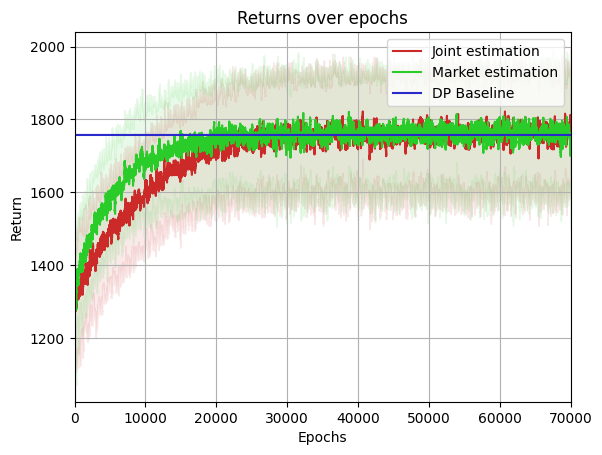

In [10]:
with open("results/Exp23/Exp_NN-PG-a_env_red_toy3.pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp1 = exp["R_exp"]
 

with open("results/Exp23/Exp_NN-PG_env_red_toy3.pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp2 = exp["R_exp"]
 
DP_expected = 1757.5

R_exp = [R_exp1[0], R_exp2[0],DP_expected*np.ones(len(R_exp1[0])) ]
from algorithms.utils import generate_random_colors

num_plots = len(R_exp)  # Número de gráficas
colors = ['#' + ''.join(np.random.choice(list('0123456789ABCDEF'), size=6)) for _ in range(num_plots)]
colors = generate_random_colors(num_plots)
labels = ["Joint estimation", "Market estimation","DP Baseline"]
for i, R in enumerate(R_exp):

    Rs = np.array(R).ravel()

    mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[i],label= labels[i])
    plt.fill_between(time, mean - std, mean + std, color=colors[i], alpha=0.1)

    plt.xlim(0, len(Rs))
    plt.grid()
    plt.ylabel("Return")
    plt.xlabel("Epochs")
    plt.legend()
    plt.title("Returns over epochs")


In [2]:
env = env_hubs2(model="Exp", T=1000)
s, _ = env.set_initial(s = [0]*env.I)
s_t = []
r_t = []

In [3]:
max_steps = 1000
p = 1

R = 0
start_time = time.time()
for step in range(max_steps):

    if p == 0:
        a = [1,1,1,1,1,0,0,0,0,0,0,0,0]
    elif p == 1:
        a = [1,1,1,1,1,1,1,1,1,1,1,1,1]
    elif p == 2:
        a = list(np.random.choice([0, 1], size=13))
            
    s_prime, r, done, _, _ = env.step(a)
    s_t.append(s_prime-s)
    r_t.append(r)
    s = s_prime
    
    R += r

    if done:
        S = s_prime
        break

end_time = time.time()



NameError: name 'time' is not defined

<StemContainer object of 3 artists>

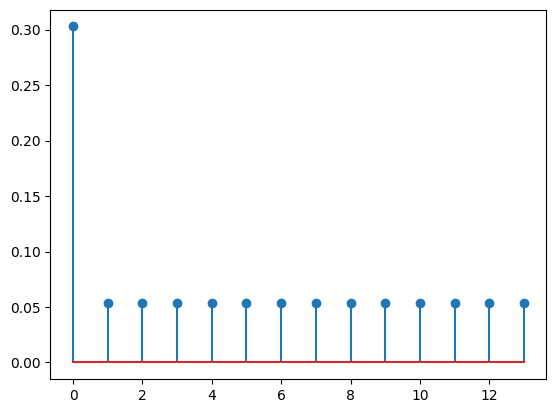

In [8]:
plt.stem(env.P_j_dist(a = [1,1,1,1,1,1,1,1,1,1,1,1,1]))

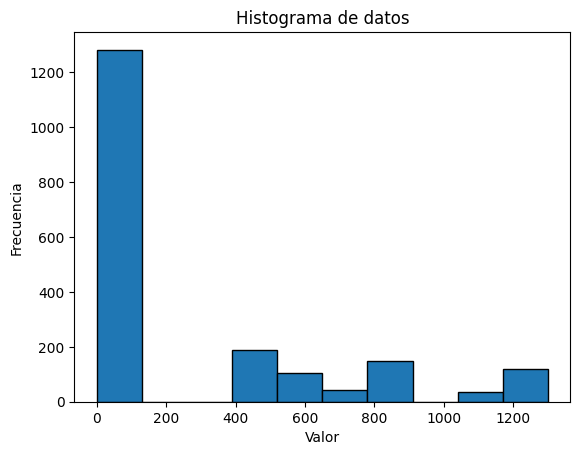

In [110]:
# Crear el histograma
plt.hist(r_t, edgecolor='black')  # Especificamos el número de bins y el color del borde
plt.title('Histograma de datos')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

/home/jorejuela/Code/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1433: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  xi = np.asanyarray(xi)


ValueError: x must have 2 or fewer dimensions

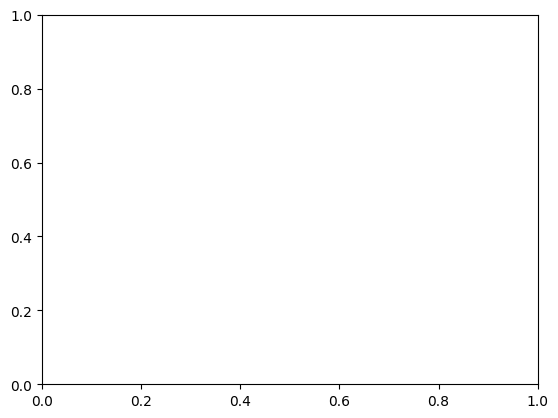

In [81]:
n_t = []
for s_i in s_t:
    
    # Filtrar los valores no deseados (por si acaso)
    bits_filtrados = [1 if bit else 0 for bit in s_i[:-1]]

    # Convertir la lista de bits a una cadena binaria como una cadena de texto
    cadena_binaria = ''.join(map(str, bits_filtrados))

    # Convertir la cadena binaria a un número entero
    numero_entero = int(cadena_binaria, 2)

    n_t.append(numero_entero)

# Crear el histograma
plt.hist(n_t, edgecolor='black')  # Especificamos el número de bins y el color del borde
plt.title('Histograma de datos')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

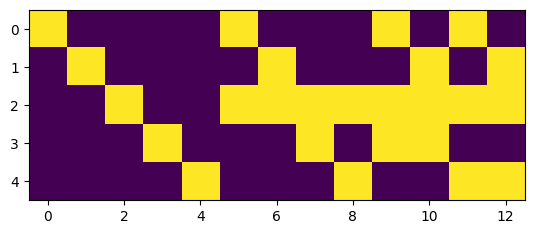

In [2]:
env = env_hubs2(model="Exp", T=3000)
plt.imshow(env.A_ij)

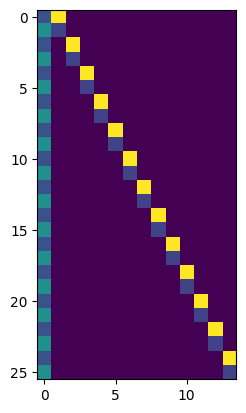

In [3]:
plt.imshow(env.v_lj)

Numero de productos 13
Acción de logitud 13 (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
LLega cliente 24
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
13


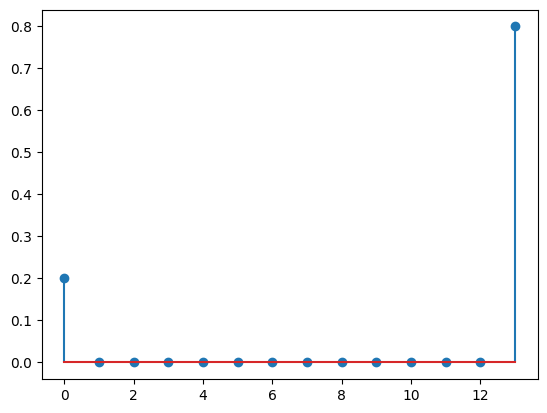

In [4]:
def integer_to_binary_tuple(integer, word_size):
    # Obtener la representación binaria del número entero sin el prefijo '0b'
    binary_str = bin(integer)[2:]

    # Asegurarse de que la cadena binaria tenga el tamaño deseado llenando con ceros a la izquierda si es necesario
    binary_str = binary_str.zfill(word_size)

    # Crear una tupla con cada bit del número binario
    binary_tuple = tuple(int(bit) for bit in binary_str)
    return binary_tuple

print(f"Numero de productos {env.J}")
a = (2**env.J)-1 
a = integer_to_binary_tuple(a, env.J)
print(f"Acción de logitud {len(a)} {a}")
env.P_j_dist_dado_l
if np.random.choice([0,1],p=[1-env.lambd, env.lambd]) == 1:
    cliente = np.random.choice(env.L,p=env.p_l)
    print(f"LLega cliente {cliente}")
    dist = env.P_j_dist_dado_l(a,cliente)
    print(dist[1:])
    plt.stem(dist)
    sample = np.random.choice(len(dist), p=dist)
else:
    print("Cliente no llega")
    sample = 0

print(sample)

In [16]:
import pickle

name_exp = "Exp14"#"Exp12"
Red_name = "hub2"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "NN-PG" #Puede ser LR/NN

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

Qfun = exp["qfun_exp"][0]
R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]

In [17]:
time_exp

[17035.662306308746]

In [6]:
import pickle

name_exp = "Exp15"#"Exp12"
Red_name = "hub2"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "NN-PG" #Puede ser LR/NN

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

Qfun = exp["qfun_exp"][0]
R_exp = exp["R_exp"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


168150


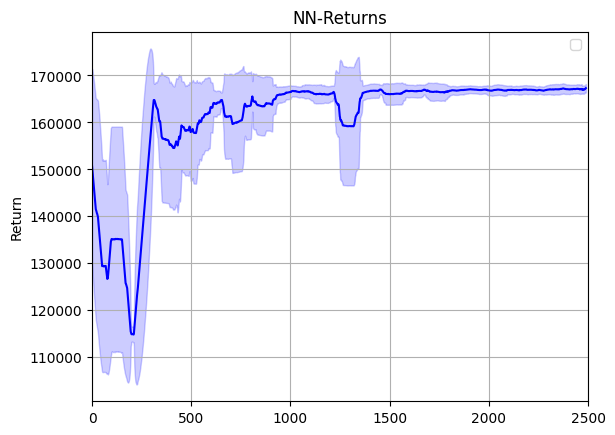

In [14]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(1)
Rs = np.array(R_exp[0][:2500]).ravel()

mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b')
#plt.plot(Rsim, color = 'r')
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)

plt.xlim(0, len(Rs))
plt.grid()
plt.ylabel("Return")
plt.legend()
plt.title("NN-Returns")
plt.show()

#plt.savefig("results/"+ name_exp + "/Returns_" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

print(R_exp[0][2500])

In [10]:
Qfun.policy

SoftmaxAgent(
  (actor): PolicyNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=26, bias=True)
    )
  )
  (critic): ValueNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [9]:
env = env_hubs2(model="Exp", T=1000)
num_sim = 50
max_steps = env.T

Rs = []
R_t= []
S_sf = []
Num_politicas = 3

for p in range(Num_politicas):
    rs = []
    s_t = []
    r_t = []
    s_sf = []
    for episode in range(num_sim):
        s, _ = env.set_initial(s = [0]*env.I)
        R = 0
        for step in range(max_steps):

            if p == 0:
                a = [1,1,1,1,1,0,0,0,0,0,0,0,0]
            elif p == 1:
                a = [1,1,1,1,1,1,1,1,1,1,1,1,1]
            elif p == 2:
                a = list(np.random.choice([0, 1], size=13))
            elif p == 3:
                a = Qfun.policy.pi(s).sample().cpu()
            
            s_prime, r, done, _, _ = env.step(a)
   
            r_t.append(r)
            s_t.append(s)

            R += r

            if done:
                S = s_prime
                break
                    
        rs.append(R)
        s_sf.append(S)
    S_sf.append(s_sf)
    Rs.append(rs)



[1384.52, 327.3, 679.66]
[96196.0, 81534.0, 81548.0]


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

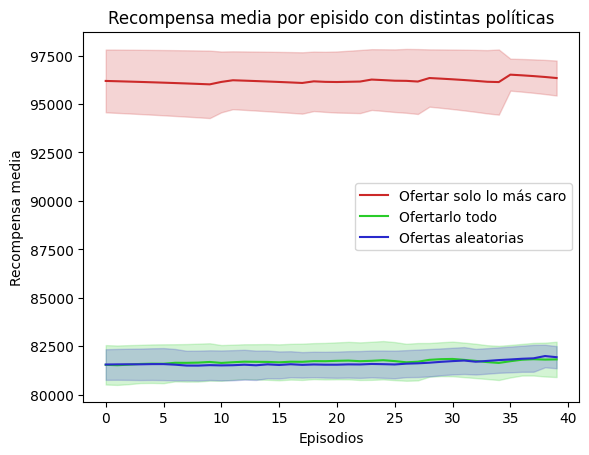

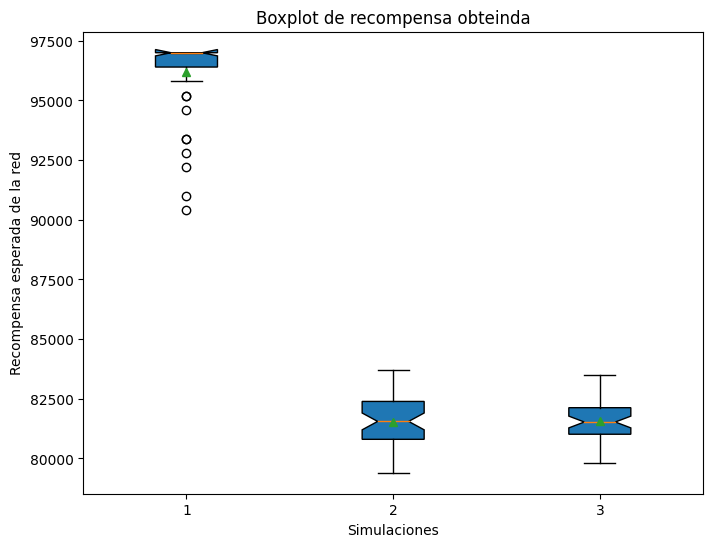

In [8]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(Num_politicas)
etiqueta =  ["Ofertar solo lo más caro", "Ofertarlo todo", "Ofertas aleatorias","pi"]

for p in range(Num_politicas):
    
    totals = Rs[p]
    x = np.array(totals).ravel()

    mean = np.array([np.mean(x[i:i+100]) for i in range(len(x) - 10)])
    std = np.array([np.std(x[i:i+100]) for i in range(len(x) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[p],label = etiqueta[p])
    #plt.plot(Rsim, color = 'r')
    plt.fill_between(time, mean - std, mean + std, color=colors[p], alpha=0.2)
    plt.title("Recompensa media por episido con distintas políticas")
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.legend()
    

T_tf_mean = []
for i in range(Num_politicas):
    t_tf = []
    for x in S_sf[i]:
        t_tf.append(x[5])
    T_tf_mean.append(np.mean(t_tf))

print(T_tf_mean)

Rs_f_mean = []
for i in range(Num_politicas):
    Rs_f_mean.append(np.mean(Rs[i]))

print(Rs_f_mean)

datos = Rs
plt.figure(figsize=(8, 6))
plt.boxplot(datos, patch_artist=True, notch=True, showmeans=True)

plt.title('Boxplot de recompensa obteinda')
plt.xlabel('Simulaciones')
plt.ylabel('Recompensa esperada de la red')
plt.xticks(range(1,Num_politicas+1),etiqueta)  # Cambiar etiquetas del eje x
plt.grid(True)

plt.show()


In [40]:
env = env_hubs2(model="Exp", T=1000)
num_sim = 10
max_steps = env.T

Rs = []
R_t= []
S_sf = []

for p in range(4):
    rs = []
    s_t = []
    r_t = []
    s_sf = []
    for episode in range(num_sim):
        s, _ = env.set_initial(s = [0]*env.I)
        R = 0
        for step in range(max_steps):

            if p == 0:
                a = [1,1,1,1,1,0,0,0,0,0,0,0,0]
            elif p == 1:
                a = [1,1,1,1,1,1,1,1,1,1,1,1,1]
            elif p == 2:
                a = [1,1,1,1,1,1,1,1,1,1,1,1,1]
            elif p == 3:
                a = list(np.random.choice([0, 1], size=13))
            
            s_prime, r, done, _, _ = env.step(a)
   
            r_t.append(r)
            s_t.append(s)

            R += r

            if done:
                S = s_prime
                break
                    
        rs.append(R)
        s_sf.append(S)
    S_sf.append(s_sf)
    Rs.append(rs)

T_tf_mean = []
for i in range(3):
    t_tf = []
    for x in S_sf[i]:
        t_tf.append(x[5])
    T_tf_mean.append(np.mean(t_tf))

print(T_tf_mean)

Rs_f_mean = []
for i in range(3):
    Rs_f_mean.append(np.mean(Rs[i]))

print(Rs_f_mean)

[999.0, 660.1, 656.8]
[125140.0, 162110.0, 162815.0]


[1999.0, 682.2, 1199.5]
[168320.0, 163350.0, 163025.0]


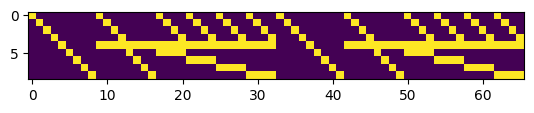

In [2]:
env = env_hubs0(model="Exp", T=2000)
plt.imshow(env.A_ij)

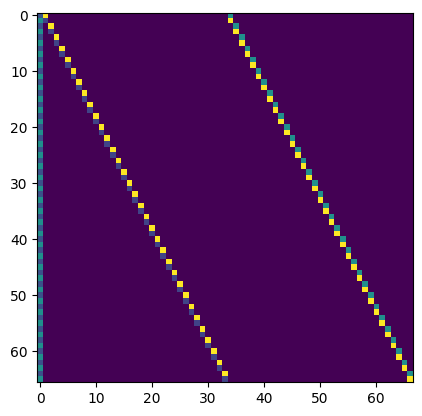

In [3]:

plt.imshow(env.v_lj)

In [9]:
sum(env.p_l)

1.0000000000000013

Numero de productos 66
Acción de logitud 66 (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
LLega cliente 65
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.11764706 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.58823529]
0


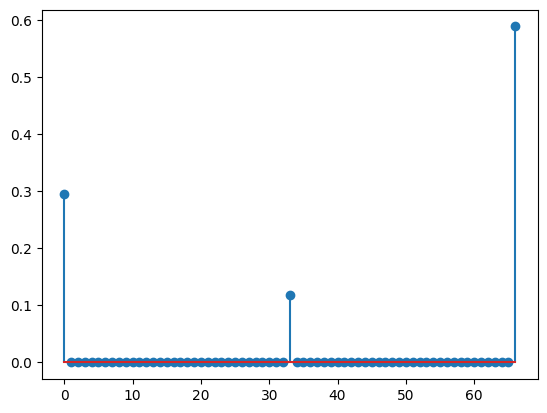

In [8]:
def integer_to_binary_tuple(integer, word_size):
    # Obtener la representación binaria del número entero sin el prefijo '0b'
    binary_str = bin(integer)[2:]

    # Asegurarse de que la cadena binaria tenga el tamaño deseado llenando con ceros a la izquierda si es necesario
    binary_str = binary_str.zfill(word_size)

    # Crear una tupla con cada bit del número binario
    binary_tuple = tuple(int(bit) for bit in binary_str)
    return binary_tuple

print(f"Numero de productos {env.J}")
a = (2**env.J)-1 
a = integer_to_binary_tuple(a, env.J)
print(f"Acción de logitud {len(a)} {a}")
env.P_j_dist_dado_l
if np.random.choice([0,1],p=[1-env.lambd, env.lambd]) == 1:
    cliente = np.random.choice(env.L,p=env.p_l)
    print(f"LLega cliente {cliente}")
    dist = env.P_j_dist_dado_l(a,cliente)
    print(dist[1:])
    plt.stem(dist)
    sample = np.random.choice(len(dist), p=dist)
else:
    print("Cliente no llega")
    sample = 0

print(sample)

In [10]:
class Buffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.terminals = []

    def clear(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.terminals = []

    def __len__(self):
        return len(self.states)

In [11]:
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn

class SoftmaxAgent(nn.Module):
    def __init__(self, actor, critic, discretizer_actor=None, discretizer_critic=None) -> None:
        super(SoftmaxAgent, self).__init__()

        self.actor = actor
        self.critic = critic

        self.discretizer_actor = discretizer_actor
        self.discretizer_critic = discretizer_critic

    def pi(self, state: np.ndarray) -> torch.distributions.Normal:
        state = torch.as_tensor(state).double()

        # Parameters
        if self.discretizer_actor:
            state = state.numpy().reshape(-1, len(self.discretizer_actor.buckets))
            indices = self.discretizer_actor.get_index(state)
            logits = self.actor(indices).squeeze()
        else:
            logits = self.actor(state).squeeze()

        # Distribution
        pi = torch.distributions.categorical.Categorical(logits=logits)
        return pi

    def evaluate_logprob(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        # Actor
        dist = self.pi(state)
        action_logprob = dist.log_prob(action)
        return action_logprob.squeeze()

    def evaluate_value(self, state: torch.Tensor) -> torch.Tensor:
        # Critic
        if self.discretizer_critic:
            state = state.numpy().reshape(-1, len(self.discretizer_actor.buckets))
            indices = self.discretizer_critic.get_index(state)
            value = self.critic(indices)
            return value.squeeze()
        value = self.critic(state)
        return value.squeeze()

    def act(self, state: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        dist = self.pi(state)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        return action.detach().flatten(), action_logprob.detach().flatten()


In [12]:
from typing import Tuple, List

import numpy as np
import torch


class ReinforceSoftmaxNN:
    def __init__(
            self,
            actor,
            critic,
            discretizer_actor=None,
            discretizer_critic=None,
            gamma=0.99,
            tau=0.97,
            epochs: int=1000,
            lr_actor=1e-2,
        ):
        self.gamma = gamma
        self.tau = tau
        self.epochs = epochs

        self.buffer = Buffer()
        self.policy = SoftmaxAgent(actor, critic, discretizer_actor, discretizer_critic)
        self.opt_actor = torch.optim.Adam(self.policy.actor.parameters(), lr_actor)

        self.opt_critic = torch.optim.LBFGS(
            self.policy.critic.parameters(),
            history_size=100,
            max_iter=25,
            line_search_fn='strong_wolfe',
        )

    def select_action(self, state: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            state = torch.as_tensor(state).double()
            action, action_logprob = self.policy.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)

        return action.item()

    def calculate_returns(self, values) -> List[float]:
        returns = []
        advantages=[]

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(len(self.buffer.rewards))):
            reward = self.buffer.rewards[i]
            mask = 1 - self.buffer.terminals[i]

            actual_return = reward + self.gamma*prev_return*mask
            actual_delta = reward + self.gamma*prev_value*mask - values[i]
            actual_advantage = actual_delta + self.gamma*self.tau*prev_advantage*mask        

            returns.insert(0, actual_return)
            advantages.insert(0, actual_advantage)

            prev_return = actual_return
            prev_value = values[i]
            prev_advantage = actual_advantage

        returns = torch.as_tensor(returns).double().detach().squeeze()
        advantages = torch.as_tensor(advantages).double().detach().squeeze()
        advantages = (advantages - advantages.mean())/advantages.std()

        return returns, advantages

    def zero_grad(self, model, idx=None):
        if idx is None:
            return

        for i, param in enumerate(model.parameters()):
            if i != idx:
                param.grad.zero_()

    def update_critic(self, idx=None):
        states = torch.stack(self.buffer.states, dim=0).detach()

        # GAE estimation
        values = self.policy.evaluate_value(states)
        rewards, advantages = self.calculate_returns(values.data.numpy())

        # LBFGS training
        def closure():
            self.opt_critic.zero_grad()
            values = self.policy.evaluate_value(states)
            loss = (values - rewards).pow(2).mean()
            loss.backward()
            self.zero_grad(self.policy.critic, idx)
            return loss
        self.opt_critic.step(closure)

        return advantages

    def update_actor(self, advantages, idx=None):
        states = torch.stack(self.buffer.states, dim=0).detach()
        actions = torch.stack(self.buffer.actions, dim=0).detach().squeeze()

        # Stochastic Gradient Ascent
        for _ in range(self.epochs):
            logprobs = self.policy.evaluate_logprob(states, actions)
            loss_actor = -logprobs*advantages
            self.opt_actor.zero_grad()
            loss_actor.mean().backward()
            self.zero_grad(self.policy.actor, idx)
            self.opt_actor.step()

In [13]:
from typing import Tuple


class Trainer:
    def __init__(self, actor_opt, critic_opt):
        self.actor_opt = actor_opt
        self.critic_opt = critic_opt

    def _update(self, agent):
        if self.actor_opt == 'bcd':
            n_params_critic = len(list(agent.policy.critic.parameters()))
            for i in range(n_params_critic):
                advantages = agent.update_critic(i)
        else:
            advantages = agent.update_critic()

        if self.critic_opt == 'bcd':
            n_params_actor = len(list(agent.policy.actor.parameters()))
            for i in range(n_params_actor):
                agent.update_actor(advantages, i)
        else:
            agent.update_actor(advantages)

        agent.buffer.clear()

    def train(
        self,
        env,
        agent,
        epochs: int,
        max_steps: int,
        update_freq: int,
        initial_offset: int,
    ):
        returns = []
        timesteps = []
        favorable_routes = 0
        self.high_reward_states = []
        for epoch in range(epochs):
            state, _ = env.reset()
            cum_reward = 0

            for t in range(max_steps):
                action = agent.select_action(state)
                state_next, reward, done, _, _ = env.step(action)


                if t + 1 == max_steps:
                    done = True

                agent.buffer.rewards.append(reward)
                agent.buffer.terminals.append(done)
                cum_reward += reward

                if len(agent.buffer) >= update_freq and epoch > initial_offset:
                    self._update(agent)

                if done:
                    break

                state = state_next
            returns.append(cum_reward)
            timesteps.append(t)
            print(f'{epoch}/{epochs}: {returns[-1]}, Num. High rewuards \r', end='')
        return agent, returns, timesteps

In [14]:

class PolicyPARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0, model='gaussian'):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

        self.model = model
        if model == 'gaussian':
            self.log_sigma = torch.nn.Parameter(torch.zeros(1))

    def forward(self, indices):
        indices = indices.long()
        if len(indices.shape) == 1:
            indices = indices.view(1, -1)
        bsz = indices.shape[0]
        prod = torch.ones(bsz, self.k, dtype=torch.double)
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if indices.shape[1] < len(self.factors):
            res = torch.matmul(prod, self.factors[-1].T)
        else:
            res = torch.sum(prod, dim=-1)
        if self.model == 'gaussian':
            return res, torch.clamp(self.log_sigma, min=-2.5, max=0.0)
        return res


class ValuePARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

    def forward(self, indices):
        indices = indices.long()
        bsz = indices.shape[0]
        prod = torch.ones(bsz, self.k, dtype=torch.double)
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if indices.shape[1] < len(self.factors):
            return torch.matmul(prod, self.factors[-1].T)
        return torch.sum(prod, dim=-1)


In [16]:
env = env_hubs0(model="Exp", T=2000)

dimensions_actor = list(env.C + 1)
dimensions_actor.append(env.T+1)

dimensions_actor.extend([3]*33)


dimensions_critic = list(env.C + 1)
dimensions_critic.append(env.T+1)

freq = 5000

lr_actor = 1e-3

k = 5




In [17]:
Trainer = Trainer("sgd", "sgd")

In [18]:
actor = PolicyPARAFAC(dimensions_actor, k=k, model= "SoftMax", scale = 1)
critc = ValuePARAFAC(dimensions_critic, k=k, scale = 1)



agent = ReinforceSoftmaxNN(actor, critc,discretizer_actor=None,discretizer_critic=None, gamma=1, tau=1, lr_actor=lr_actor)

In [30]:
s, _ =env.reset()
agent.policy.act(s)

(tensor([2]), tensor([-1.1035], dtype=torch.float64))

In [ ]:
agent , totals,_ = Trainer.train(env, agent, epochs=7000, max_steps=300, update_freq=freq, initial_offset=0)

Rs = totals
mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b',label= "Exp")
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)
plt.grid()
plt.show()

In [9]:
import time
num_sim = 1000
max_steps = env.T

Rs = []
r_t= []
s_t = []
a_t = []

for episode in range(num_sim):
    s, _ = env.set_initial(s = [0]*env.I)
    R = 0
    for step in range(max_steps):

        a = 2**(env.J) - 1
        start_time = time.time()
        s_prime, r, done, _, _ = env.step(a)
        end_time = time.time()
        print(end_time-start_time)    
        r_t.append(r)
        s_t.append(s)
        a_t.append(a) 

        R += r

        if done:
            break
                
        s = s_prime
    print(s)
    Rs.append(R)

0.00171661376953125
0.0004417896270751953
0.0003135204315185547
0.00031828880310058594
0.00031065940856933594
0.0003113746643066406
0.0002994537353515625
0.00030803680419921875
0.00030231475830078125
0.0002999305725097656
0.0003151893615722656
0.00030732154846191406
0.0003032684326171875
0.00031280517578125
0.00030303001403808594
0.0003006458282470703
0.00030112266540527344
0.0003001689910888672
0.000301361083984375
0.0002944469451904297
0.00029969215393066406
0.0002970695495605469
0.0002980232238769531
0.0003261566162109375
0.0002987384796142578
0.0002949237823486328
0.0003006458282470703
0.00030040740966796875
0.0002987384796142578
0.00029850006103515625
0.00030112266540527344
0.00031113624572753906
0.00031065940856933594
0.00037407875061035156
0.0003104209899902344
0.0003039836883544922
0.0003151893615722656
0.00030517578125
0.0003018379211425781
0.0003006458282470703
0.0002963542938232422
0.0002923011779785156
0.0003006458282470703
0.0003008842468261719
0.00029969215393066406
0.000

KeyboardInterrupt: 

In [ ]:
env.action_space[0]

In [ ]:


print(action_space_generation(3, 2))

In [ ]:
def action_space_generation(J,ini_num_actions):
    return random.sample(list(product([0,1], repeat=J)), ini_num_actions)

print(action_space_generation(10, 2))

In [ ]:
carpeta = "results/Exp5"
Demand_Model = "Exp"
Red_name = "red1"

In [ ]:
T = 400
env = env_red_toy1(Demand_Model,T)
# DQL
Qfun_model = "NN"
with open(carpeta +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    data = pickle.load(f)

qnet_exp = data["qfun_exp"]

#LRQL
Qfun_model = "LR"
with open(carpeta +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    data = pickle.load(f)
    
qtensor_exp = data["qfun_exp"]

In [ ]:
num_sim = 1000
max_steps = 400
Qfun = qtensor_exp[0]
model = "LR"

Rs = []
r_t= []
s_t = []
a_t = []

for episode in range(num_sim):
    s, _ = env.set_initial(s = [0]*env.I)
    R = 0
    for step in range(max_steps):

        if model == "NN":
            a = select_action(Qfun, s, 0, 2**(env.J))
        if model == "LR":
            a = select_action_LR(Qfun, s, 0,  2**(env.J))

        s_prime, r, done, _, _ = env.step(a)
            
        r_t.append(r)
        s_t.append(s)
        a_t.append(a) 

        R += r

        if done:
            break
                
        s = s_prime
    Rs.append(R)

In [ ]:
def compare_Qfun(env, Qfun1, Qfun2, model1, model2):

    s_vecors = [range(0,c) for c in env.C]
    s_vecors.append(range(env.T-1))
    dif = 0  # Inicializar el máximo como negativo infinito
    
    for s_i in (product(*s_vecors)):

        s = torch.tensor(s_i, dtype=torch.double)

        if model1 == "NN":
            val1 = torch.max(Qfun1(s)).item()
        elif model1 == "LR":
            val1 = torch.max(Qfun1(torch.tensor(s_i, dtype=torch.long).view(1, -1))).item()

        if model2 == "NN":
            val2 = torch.max(Qfun2(s)).item()
        elif model2 == "LR":
            val2 = torch.max(Qfun2(torch.tensor(s_i, dtype=torch.long).view(1, -1))).item()

        dif += abs(val1-val2)

    return dif

In [ ]:
def compare_Qfun_exp(env,Qfun_list, model,name):
    data = np.zeros((len(Qfun_list), len(Qfun_list)))
    for q1 in range(len(Qfun_list)):
        for q2 in range(q1+1,len(Qfun_list)):
            diff = compare_Qfun(env, Qfun_list[q1], Qfun_list[q2], model, model)
            data[q1, q2] = diff
            data[q2, q1] = diff
    plt.imshow(np.array(data))
    plt.title("Diferencia en las funciones de valor")
    plt.xlabel("Exp1")
    plt.ylabel("Exp2")
    plt.colorbar()
    plt.savefig(name)

In [ ]:
compare_Qfun_exp(env,qnet_exp,"NN","Prueba")

In [ ]:
print(diff_matrix)

In [ ]:
plt.imshow(np.array(diff_matrix))
plt.title("Diferencia en las funciones de valor")
plt.xlabel("Exp1")
plt.ylabel("Exp2")
plt.colorbar()


In [ ]:
# DQL
env = env_red_toy()

nS = env.I + 1
nA =  2**(env.J)
nH = 128

qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
).double()

qnet.load_state_dict(torch.load("results/qnet_toy.pth"))

In [ ]:
def get_toy_slide(qnet, t, states_map,C_1,C_2):
    t = 0
    data = np.zeros((len(C_1),len(C_2)))
    for (x1,x2) in (list(product(C_1,C_2))):
        idx = states_map[(x1,x2,t)]
        s = torch.tensor([x1,x2, t], dtype=torch.double)
        data[x1,x2] = torch.max(qnet(s))
    return data

In [ ]:
C_1 = range(0,env.C[0])
C_2 = range(0,env.C[1])
T_RANGE = range(0,env.T)

states_map = {}

for idx, (x1,x2, t) in enumerate(list(product(C_1,C_2,T_RANGE))):
            states_map[(x1,x2, t)] = idx

vmax = torch.max(qnet(torch.tensor([0,0, 0], dtype=torch.double)))

data = get_toy_slide(qnet, t, states_map,C_1,C_2)

plt.imshow(data, cmap='inferno', interpolation='nearest',vmin=0, vmax=vmax)
    
plt.colorbar()  # Agregar barra de colores para referencia
plt.title(f'V(s)-DQL_toy ,t =  {t}')
plt.xlabel('Asientos vendidos, x2')
plt.ylabel('Asientos vendidos, x1')


In [ ]:
def get_tensor_from_net(qnet,env):
    dimensiones = [c for c in env.C]
    dimensiones.append(env.T)
    #dimensiones.append(len(env.action_space))

    tensor = torch.zeros(dimensiones)
    # Genera las combinaciones de índices usando itertools.product
    combinaciones = product(*(range(valor) for valor in dimensiones))

    # Itera sobre las combinaciones
    for combinacion in combinaciones:
        #tensor[combinacion] = qnet(torch.tensor(combinacion[:-1],dtype=torch.double))[combinacion[-1]]
        tensor[combinacion] = torch.max(qnet(torch.tensor(combinacion,dtype=torch.double)))
    return tensor

tensor = get_tensor_from_net(qnet,env)



In [ ]:
rank = tf.rank(tensor.detach().numpy())
print(rank)

k = 5
# Realizar la descomposición PARAFAC
CPTensor, err = tl.decomposition.parafac(tensor.detach().numpy(),rank=k, return_errors = True)

factors = []
for factor in CPTensor.factors:
    factors.append(torch.tensor(factor))

plt.plot(err)
plt.grid()
plt.title("Error of parafact over the approx")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()


In [ ]:
def tensor_forward(factors,k,indices):
    bsz = indices.shape[0]
    prod = torch.ones(bsz, k, dtype=torch.double)
    for i in range(indices.shape[1]):
        idx = indices[:, i]
        factor = factors[i]
        prod *= factor[idx, :]
    if indices.shape[1] < len(factors):
        return torch.matmul(prod, factors[-1].T)
    return torch.sum(prod, dim=-1)




In [ ]:
# Función para generar datos de la imagen
def generate_data(frame):
    t = frame
    data = np.zeros((len(C_1),len(C_2)))
    for (x1,x2) in (list(product(C_1,C_2))):
        s = torch.tensor([x1,x2, t], dtype=torch.long).view(1, -1)
        data[x1,x2] =tensor_forward(factors,k,s)
    return data

# Función para la animación
def animate(frame):
    plt.clf()  # Limpiar el gráfico en cada frame
    data = generate_data(frame)
    plt.imshow(data, cmap='inferno', interpolation='nearest')
    
    plt.colorbar()  # Agregar barra de colores para referencia
    plt.title(f'V(s)-DQL_toy ,Frame {frame}')
    plt.xlabel('Asientos vendidos, x2')
    plt.ylabel('Asientos vendidos, x1')
    

# Crear la figura
fig, ax = plt.subplots()

# Crear la animación
animation = FuncAnimation(fig, animate, frames=50, interval=200)

# Guardar la animación en un archivo GIF
animation.save('DQL-to_tensor-reconstruida.gif', writer='imagemagick', fps=5)

# Mostrar el gráfico
plt.show()